# Pipeline Lengkap: Prediksi Suhu dengan LSTM

## TA-04: Prediksi Data Time Series Menggunakan LSTM

**Tujuan:**
- Membangun pipeline lengkap untuk prediksi suhu menggunakan LSTM
- Melakukan eksplorasi dan pembersihan data
- Melatih model LSTM untuk prediksi time series
- Membuat aplikasi web Flask untuk deployment

---

## 1. Persiapan Environment & Reproducibility

In [1]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import joblib
import random
import os
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Library berhasil diimport!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Library berhasil diimport!
TensorFlow version: 2.20.0
NumPy version: 2.3.4
Pandas version: 2.3.3


In [2]:
# Set seed untuk reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print("✅ Seed berhasil diatur untuk reproducibility!")

✅ Seed berhasil diatur untuk reproducibility!


## 2. Load & Eksplorasi Data (EDA)

In [3]:
# Load dataset
df = pd.read_csv('cleaned_weather.csv', parse_dates=['date'], index_col='date')

print("✅ Dataset berhasil dimuat!")
print(f"\nJumlah baris: {len(df)}")
print(f"Periode data: {df.index.min()} hingga {df.index.max()}")
print(f"\nKolom dataset:")
print(df.columns.tolist())

✅ Dataset berhasil dimuat!

Jumlah baris: 52696
Periode data: 2020-01-01 00:10:00 hingga 2021-01-01 00:00:00

Kolom dataset:
['p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho', 'wv', 'max. wv', 'wd', 'rain', 'raining', 'SWDR', 'PAR', 'max. PAR', 'Tlog']


In [4]:
# Rename kolom ke bahasa Indonesia
kolom_indonesia = {
    'p': 'tekanan_udara',
    'T': 'suhu',
    'Tpot': 'suhu_potensial',
    'Tdew': 'titik_embun',
    'rh': 'kelembaban_relatif',
    'VPmax': 'tekanan_uap_maksimum',
    'VPact': 'tekanan_uap_aktual',
    'VPdef': 'defisit_tekanan_uap',
    'sh': 'kelembaban_spesifik',
    'H2OC': 'konsentrasi_air',
    'rho': 'densitas_udara',
    'wv': 'kecepatan_angin',
    'max. wv': 'kecepatan_angin_maks',
    'wd': 'arah_angin',
    'rain': 'curah_hujan',
    'raining': 'sedang_hujan',
    'SWDR': 'radiasi_gelombang_pendek',
    'PAR': 'radiasi_fotosintesis',
    'max. PAR': 'radiasi_fotosintesis_maks',
    'Tlog': 'suhu_logger'
}

df = df.rename(columns=kolom_indonesia)

print("✅ Kolom berhasil diubah ke bahasa Indonesia!")
print(f"\nKolom baru:")
for col in df.columns:
    print(f"  - {col}")

✅ Kolom berhasil diubah ke bahasa Indonesia!

Kolom baru:
  - tekanan_udara
  - suhu
  - suhu_potensial
  - titik_embun
  - kelembaban_relatif
  - tekanan_uap_maksimum
  - tekanan_uap_aktual
  - defisit_tekanan_uap
  - kelembaban_spesifik
  - konsentrasi_air
  - densitas_udara
  - kecepatan_angin
  - kecepatan_angin_maks
  - arah_angin
  - curah_hujan
  - sedang_hujan
  - radiasi_gelombang_pendek
  - radiasi_fotosintesis
  - radiasi_fotosintesis_maks
  - suhu_logger


In [5]:
# Informasi dasar dataset
print("=" * 60)
print("INFORMASI DATASET")
print("=" * 60)
df.info()
print("\n" + "=" * 60)
print("STATISTIK DESKRIPTIF")
print("=" * 60)
display(df.describe())
print("\n" + "=" * 60)
print("PREVIEW DATA (5 BARIS PERTAMA)")
print("=" * 60)
display(df.head())

INFORMASI DATASET
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52696 entries, 2020-01-01 00:10:00 to 2021-01-01 00:00:00
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tekanan_udara              52696 non-null  float64
 1   suhu                       52696 non-null  float64
 2   suhu_potensial             52696 non-null  float64
 3   titik_embun                52696 non-null  float64
 4   kelembaban_relatif         52696 non-null  float64
 5   tekanan_uap_maksimum       52696 non-null  float64
 6   tekanan_uap_aktual         52696 non-null  float64
 7   defisit_tekanan_uap        52696 non-null  float64
 8   kelembaban_spesifik        52696 non-null  float64
 9   konsentrasi_air            52696 non-null  float64
 10  densitas_udara             52696 non-null  float64
 11  kecepatan_angin            52696 non-null  float64
 12  kecepatan_angin_maks       52696 non-null  float6

,tekanan_udara,suhu,suhu_potensial,titik_embun,kelembaban_relatif,tekanan_uap_maksimum,tekanan_uap_aktual,defisit_tekanan_uap,kelembaban_spesifik,konsentrasi_air,densitas_udara,kecepatan_angin,kecepatan_angin_maks,arah_angin,curah_hujan,sedang_hujan,radiasi_gelombang_pendek,radiasi_fotosintesis,radiasi_fotosintesis_maks,suhu_logger
count,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,989.989233,10.818241,284.796938,5.409105,72.487133,14.487046,9.676828,4.810131,6.111159,9.782341,1210.882855,1.995935,3.632807,176.850276,0.011773,25.907469,131.331822,259.863438,308.601939,21.515206
std,9.207149,7.468671,7.616995,5.956722,19.230260,7.632960,4.023504,5.539320,2.561536,4.082684,36.430222,43.596931,2.462467,81.194840,0.123289,111.503420,215.735116,422.786515,569.956762,7.790620
min,955.580000,-6.440000,266.190000,-13.810000,21.160000,3.770000,2.090000,0.000000,1.300000,2.090000,1107.380000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.900000
25%,984.800000,4.590000,278.550000,0.777500,58.820000,8.480000,6.460000,1.170000,4.070000,6.530000,1183.900000,1.000000,1.770000,141.100000,0.000000,0.000000,0.000000,0.000000,0.000000,15.240000
50%,990.920000,10.230000,284.320000,5.260000,75.400000,12.480000,8.890000,2.740000,5.610000,8.990000,1210.800000,1.770000,3.000000,195.500000,0.000000,0.000000,2.820000,9.670000,13.120000,20.440000
75%,995.930000,16.180000,290.260000,9.700000,87.900000,18.420000,12.050000,6.440000,7.620000,12.200000,1236.550000,2.920000,4.850000,226.700000,0.000000,0.000000,182.900000,366.437500,434.260000,26.822500
max,1020.070000,34.800000,309.130000,20.500000,100.000000,55.670000,24.160000,42.100000,15.400000,24.530000,1318.520000,13.770000,22.900000,360.000000,11.200000,600.000000,1115.290000,2131.760000,2498.940000,49.090000



PREVIEW DATA (5 BARIS PERTAMA)


,tekanan_udara,suhu,suhu_potensial,titik_embun,kelembaban_relatif,tekanan_uap_maksimum,tekanan_uap_aktual,defisit_tekanan_uap,kelembaban_spesifik,konsentrasi_air,densitas_udara,kecepatan_angin,kecepatan_angin_maks,arah_angin,curah_hujan,sedang_hujan,radiasi_gelombang_pendek,radiasi_fotosintesis,radiasi_fotosintesis_maks,suhu_logger
date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


## 3. Pembersihan Data & Handling Missing Values

In [6]:
# Cek missing values
missing_values = df.isna().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Kolom': missing_values.index,
    'Jumlah Missing': missing_values.values,
    'Persentase (%)': missing_percent.values
})

missing_df = missing_df[missing_df['Jumlah Missing'] > 0].sort_values('Jumlah Missing', ascending=False)

if len(missing_df) > 0:
    print("⚠️ MISSING VALUES DITEMUKAN:")
    display(missing_df)
    
    # Handling missing values
    print("\nMelakukan interpolasi untuk mengisi missing values...")
    df = df.interpolate(method='time')
    df = df.fillna(method='bfill')
    print(f"✅ Missing values setelah interpolasi: {df.isna().sum().sum()}")
else:
    print("✅ TIDAK ADA MISSING VALUES!")

✅ TIDAK ADA MISSING VALUES!


## 4. Visualisasi Data

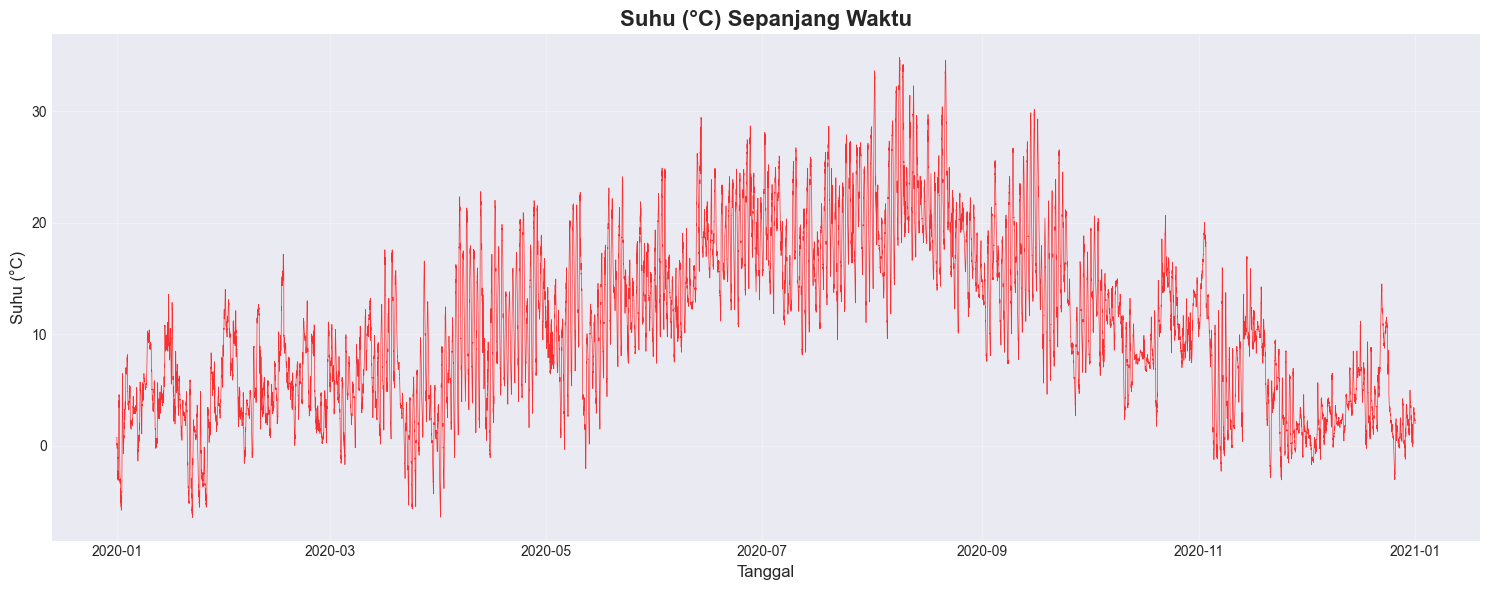

Suhu minimum: -6.44°C
Suhu maksimum: 34.80°C
Suhu rata-rata: 10.82°C
Standar deviasi: 7.47°C


In [7]:
# Plot suhu sepanjang waktu
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['suhu'], linewidth=0.5, alpha=0.8, color='red')
plt.title('Suhu (°C) Sepanjang Waktu', fontsize=16, fontweight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Suhu (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Suhu minimum: {df['suhu'].min():.2f}°C")
print(f"Suhu maksimum: {df['suhu'].max():.2f}°C")
print(f"Suhu rata-rata: {df['suhu'].mean():.2f}°C")
print(f"Standar deviasi: {df['suhu'].std():.2f}°C")

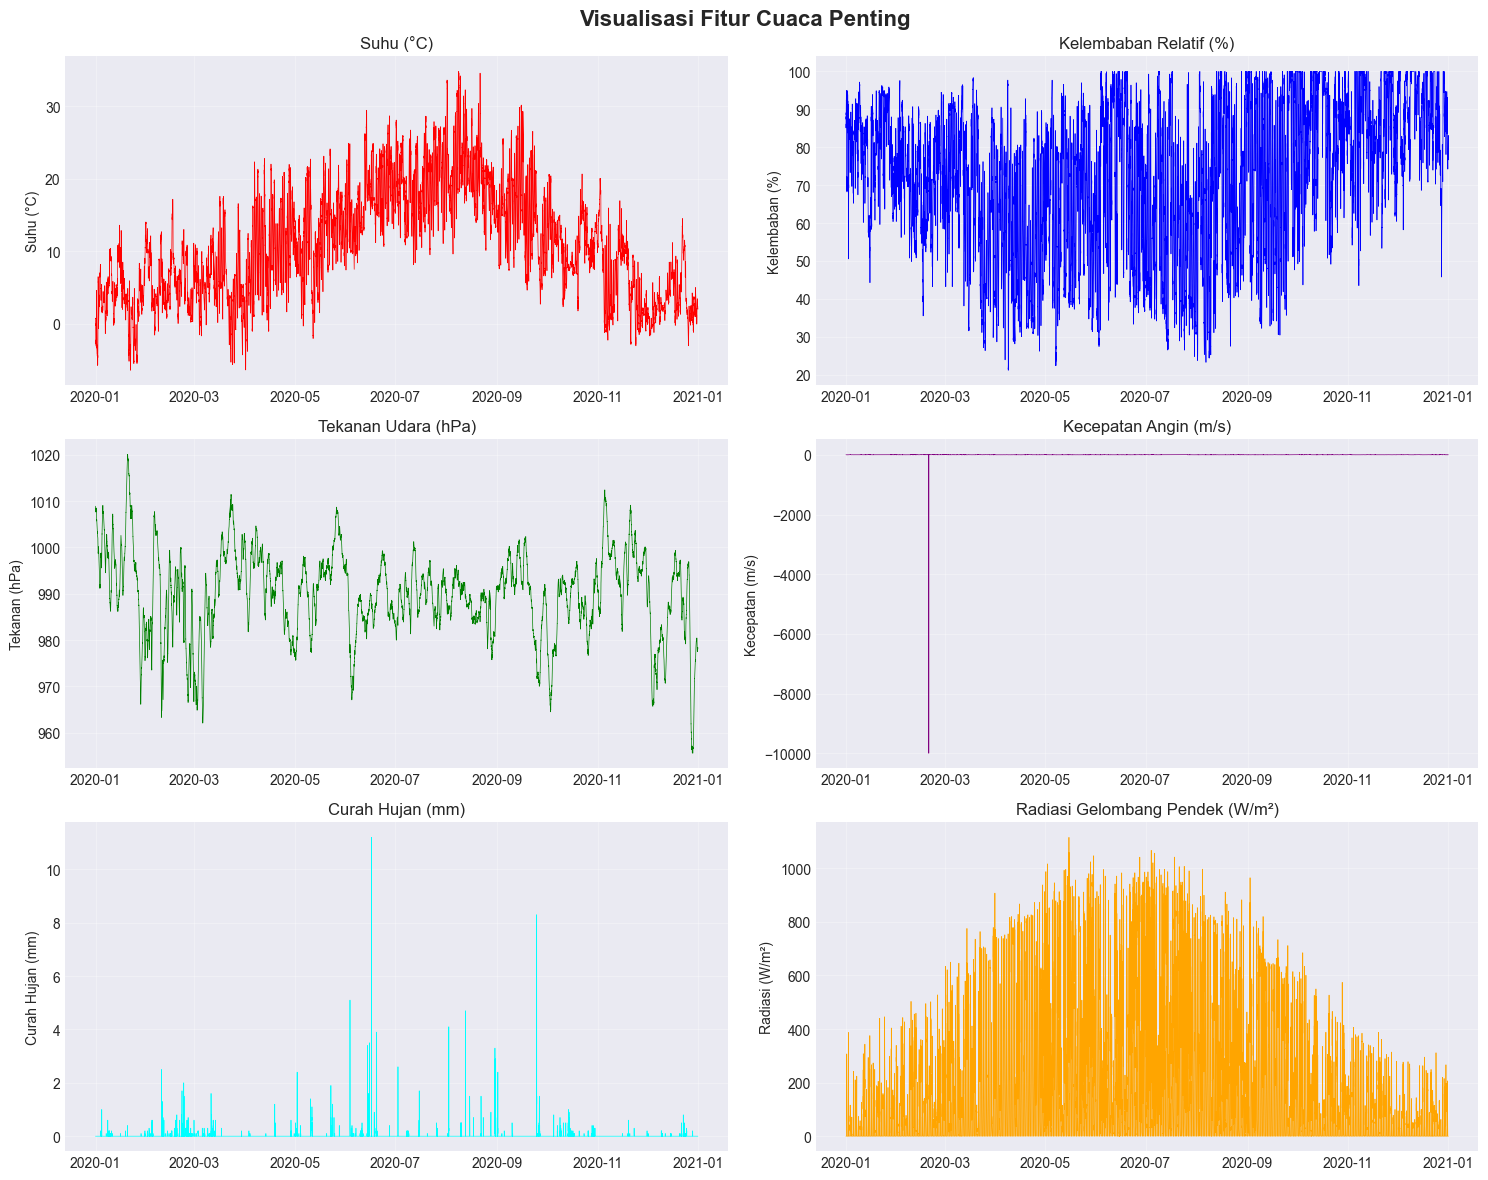

In [8]:
# Plot multiple fitur penting
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Visualisasi Fitur Cuaca Penting', fontsize=16, fontweight='bold')

axes[0, 0].plot(df.index, df['suhu'], linewidth=0.5, color='red')
axes[0, 0].set_title('Suhu (°C)')
axes[0, 0].set_ylabel('Suhu (°C)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df.index, df['kelembaban_relatif'], linewidth=0.5, color='blue')
axes[0, 1].set_title('Kelembaban Relatif (%)')
axes[0, 1].set_ylabel('Kelembaban (%)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df.index, df['tekanan_udara'], linewidth=0.5, color='green')
axes[1, 0].set_title('Tekanan Udara (hPa)')
axes[1, 0].set_ylabel('Tekanan (hPa)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(df.index, df['kecepatan_angin'], linewidth=0.5, color='purple')
axes[1, 1].set_title('Kecepatan Angin (m/s)')
axes[1, 1].set_ylabel('Kecepatan (m/s)')
axes[1, 1].grid(True, alpha=0.3)

axes[2, 0].plot(df.index, df['curah_hujan'], linewidth=0.5, color='cyan')
axes[2, 0].set_title('Curah Hujan (mm)')
axes[2, 0].set_ylabel('Curah Hujan (mm)')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(df.index, df['radiasi_gelombang_pendek'], linewidth=0.5, color='orange')
axes[2, 1].set_title('Radiasi Gelombang Pendek (W/m²)')
axes[2, 1].set_ylabel('Radiasi (W/m²)')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

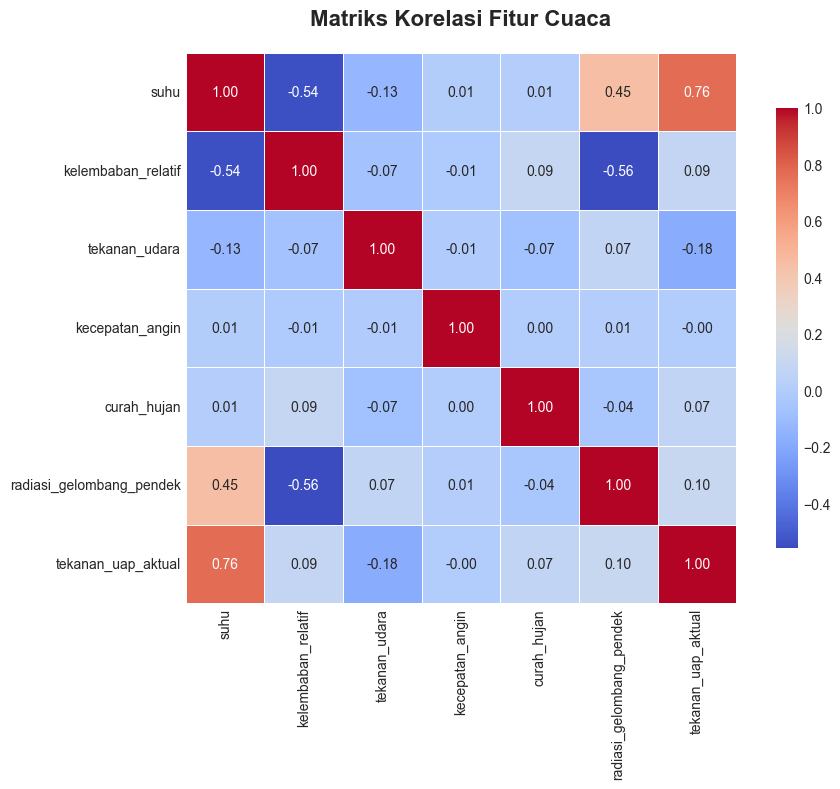


Korelasi dengan Suhu:
suhu                        1.000000
tekanan_uap_aktual          0.762860
radiasi_gelombang_pendek    0.448607
curah_hujan                 0.008448
kecepatan_angin             0.007514
tekanan_udara              -0.127305
kelembaban_relatif         -0.540784
Name: suhu, dtype: float64


In [9]:
# Correlation matrix untuk fitur numerik utama
fitur_utama = ['suhu', 'kelembaban_relatif', 'tekanan_udara', 'kecepatan_angin', 
               'curah_hujan', 'radiasi_gelombang_pendek', 'tekanan_uap_aktual']

plt.figure(figsize=(10, 8))
correlation_matrix = df[fitur_utama].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriks Korelasi Fitur Cuaca', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKorelasi dengan Suhu:")
print(correlation_matrix['suhu'].sort_values(ascending=False))

## 5. Feature Engineering

In [10]:
# Tambahkan fitur waktu
df['bulan'] = df.index.month
df['hari_dalam_tahun'] = df.index.dayofyear
df['hari_dalam_minggu'] = df.index.dayofweek
df['jam'] = df.index.hour

# Tambahkan rolling features
df['suhu_rata2_24jam'] = df['suhu'].rolling(window=144, min_periods=1).mean()  # 24 jam (data 10 menit)
df['suhu_std_24jam'] = df['suhu'].rolling(window=144, min_periods=1).std()

# Fill NaN yang dihasilkan dari rolling
df = df.fillna(method='bfill')

print("✅ Feature engineering selesai!")
print(f"\nJumlah kolom sekarang: {len(df.columns)}")
print("\nFitur baru yang ditambahkan:")
print("  - bulan")
print("  - hari_dalam_tahun")
print("  - hari_dalam_minggu")
print("  - jam")
print("  - suhu_rata2_24jam")
print("  - suhu_std_24jam")

✅ Feature engineering selesai!

Jumlah kolom sekarang: 26

Fitur baru yang ditambahkan:
  - bulan
  - hari_dalam_tahun
  - hari_dalam_minggu
  - jam
  - suhu_rata2_24jam
  - suhu_std_24jam


## 6. Persiapan Data untuk Model LSTM

In [11]:
# Pilih fitur untuk model (multivariate)
fitur_model = [
    'suhu',
    'kelembaban_relatif',
    'tekanan_udara',
    'kecepatan_angin',
    'curah_hujan',
    'radiasi_gelombang_pendek',
    'bulan',
    'hari_dalam_tahun'
]

df_model = df[fitur_model].copy()
df_model = df_model.fillna(method='bfill')

print(f"✅ Fitur yang digunakan untuk model:")
for i, fitur in enumerate(fitur_model, 1):
    print(f"  {i}. {fitur}")
    
print(f"\nShape data: {df_model.shape}")
print(f"Missing values: {df_model.isna().sum().sum()}")

✅ Fitur yang digunakan untuk model:
  1. suhu
  2. kelembaban_relatif
  3. tekanan_udara
  4. kecepatan_angin
  5. curah_hujan
  6. radiasi_gelombang_pendek
  7. bulan
  8. hari_dalam_tahun

Shape data: (52696, 8)
Missing values: 0


## 7. Scaling Data

In [12]:
# Scaling menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_model)

print("✅ Data berhasil di-scale!")
print(f"Shape data setelah scaling: {data_scaled.shape}")
print(f"\nRange data setelah scaling:")
print(f"  Min: {data_scaled.min():.4f}")
print(f"  Max: {data_scaled.max():.4f}")
print(f"\nScaler akan disimpan untuk digunakan saat prediksi!")

✅ Data berhasil di-scale!
Shape data setelah scaling: (52696, 8)

Range data setelah scaling:
  Min: 0.0000
  Max: 1.0000

Scaler akan disimpan untuk digunakan saat prediksi!


## 8. Membuat Sequences untuk LSTM

In [13]:
# Fungsi untuk membuat sequences
def create_sequences(data, timesteps=60, target_col_idx=0):
    """
    Membuat sequences untuk LSTM
    
    Parameters:
    - data: array data yang sudah di-scale
    - timesteps: jumlah timesteps untuk window
    - target_col_idx: index kolom target (0 untuk suhu)
    
    Returns:
    - X: array input sequences
    - y: array target values
    """
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i])
        y.append(data[i, target_col_idx])
    return np.array(X), np.array(y)

# Set timesteps
timesteps = 60

print(f"Membuat sequences dengan timesteps = {timesteps}...")
X, y = create_sequences(data_scaled, timesteps=timesteps, target_col_idx=0)

print(f"\n✅ Sequences berhasil dibuat!")
print(f"Shape X (input): {X.shape}")
print(f"Shape y (target): {y.shape}")
print(f"\nPenjelasan shape X: (samples, timesteps, features)")
print(f"  - Samples: {X.shape[0]}")
print(f"  - Timesteps: {X.shape[1]}")
print(f"  - Features: {X.shape[2]}")

Membuat sequences dengan timesteps = 60...

✅ Sequences berhasil dibuat!
Shape X (input): (52636, 60, 8)
Shape y (target): (52636,)

Penjelasan shape X: (samples, timesteps, features)
  - Samples: 52636
  - Timesteps: 60
  - Features: 8


## 9. Split Data (Train / Validation / Test)

In [14]:
# Split data secara time-aware (TIDAK BOLEH DIACAK!)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("✅ Data berhasil di-split!")
print("\n" + "="*60)
print("TRAINING SET")
print("="*60)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Persentase: {(len(X_train)/len(X))*100:.1f}%")

print("\n" + "="*60)
print("VALIDATION SET")
print("="*60)
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"Persentase: {(len(X_val)/len(X))*100:.1f}%")

print("\n" + "="*60)
print("TEST SET")
print("="*60)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Persentase: {(len(X_test)/len(X))*100:.1f}%")

✅ Data berhasil di-split!

TRAINING SET
X_train shape: (36845, 60, 8)
y_train shape: (36845,)
Persentase: 70.0%

VALIDATION SET
X_val shape: (7895, 60, 8)
y_val shape: (7895,)
Persentase: 15.0%

TEST SET
X_test shape: (7896, 60, 8)
y_test shape: (7896,)
Persentase: 15.0%


## 10. Arsitektur Model LSTM

In [15]:
# Build model LSTM
n_features = X_train.shape[2]

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(timesteps, n_features)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("✅ Model berhasil dibuat!")
print("\n" + "="*60)
print("ARSITEKTUR MODEL")
print("="*60)
model.summary()

✅ Model berhasil dibuat!

ARSITEKTUR MODEL


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,101 (293.36 KB)

 Trainable params: 75,101 (293.36 KB)

 Non-trainable params: 0 (0.00 B)

## 11. Training Model

In [16]:
# Setup callbacks
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Gunakan format .keras untuk menghindari masalah kompatibilitas
mc = ModelCheckpoint('models/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# Backup: simpan juga dalam format .h5
mc_h5 = ModelCheckpoint('models/best_model.h5', monitor='val_loss', save_best_only=True, verbose=0)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)

# Buat folder models jika belum ada
os.makedirs('models', exist_ok=True)

print("✅ Callbacks siap!")
print("  - EarlyStopping (patience=10)")
print("  - ModelCheckpoint (save best model dalam .keras dan .h5)")
print("  - ReduceLROnPlateau (reduce learning rate)")
print("\n" + "="*60)
print("MULAI TRAINING...")
print("="*60)

✅ Callbacks siap!
  - EarlyStopping (patience=10)
  - ModelCheckpoint (save best model dalam .keras dan .h5)
  - ReduceLROnPlateau (reduce learning rate)

MULAI TRAINING...


In [17]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es, mc, mc_h5, rl],
    verbose=1
)

print("\n✅ Training selesai!")

Epoch 1/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0096 - mae: 0.0563
Epoch 1: val_loss improved from None to 0.00037, saving model to models/best_model.keras


1152/1152 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - loss: 0.0030 - mae: 0.0342 - val_loss: 3.6789e-04 - val_mae: 0.0155 - learning_rate: 0.0010
Epoch 2/100
1151/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.7391e-04 - mae: 0.0198
Epoch 2: val_loss did not improve from 0.00037
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - loss: 5.9858e-04 - mae: 0.0186 - val_loss: 3.7461e-04 - val_mae: 0.0167 - learning_rate: 0.0010
Epoch 3/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.3083e-04 - mae: 0.0157
Epoch 3: val_loss improved from 0.00037 to 0.00032, saving model to models/best_model.keras


1152/1152 ━━━━━━━━━━━━━━━━━━━━ 59s 51ms/step - loss: 4.0601e-04 - mae: 0.0153 - val_loss: 3.1570e-04 - val_mae: 0.0133 - learning_rate: 0.0010
Epoch 4/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 3.2824e-04 - mae: 0.0137
Epoch 4: val_loss did not improve from 0.00032
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 60s 52ms/step - loss: 3.1398e-04 - mae: 0.0134 - val_loss: 3.8150e-04 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 5/100
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.8472e-04 - mae: 0.0128
Epoch 5: val_loss improved from 0.00032 to 0.00029, saving model to models/best_model.keras


1152/1152 ━━━━━━━━━━━━━━━━━━━━ 58s 50ms/step - loss: 2.6940e-04 - mae: 0.0124 - val_loss: 2.9062e-04 - val_mae: 0.0124 - learning_rate: 0.0010
Epoch 6/100
1151/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.3451e-04 - mae: 0.0115
Epoch 6: val_loss did not improve from 0.00029

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - loss: 2.2975e-04 - mae: 0.0114 - val_loss: 3.0654e-04 - val_mae: 0.0128 - learning_rate: 0.0010
Epoch 7/100
1151/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.7800e-04 - mae: 0.0099
Epoch 7: val_loss did not improve from 0.00029
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 78s 67ms/step - loss: 1.7822e-04 - mae: 0.0099 - val_loss: 6.1210e-04 - val_mae: 0.0193 - learning_rate: 5.0000e-04
Epoch 8/100
1151/1152 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.6828e-04 - mae: 0.0096
Epoch 8: val_loss did not improve from 0.00029
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 74s 64ms/step - loss: 1.7207e-04 - mae: 0.0097 - va

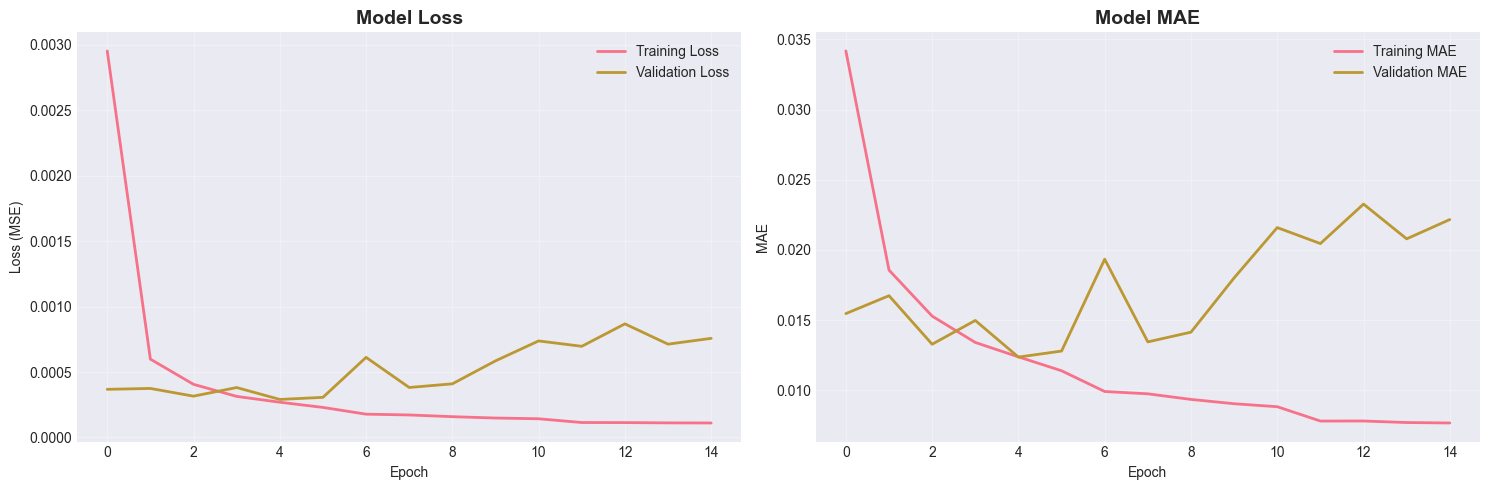

Best Training Loss: 0.000111
Best Validation Loss: 0.000291


In [26]:
# Plot learning curve
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best Training Loss: {min(history.history['loss']):.6f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.6f}")

## 12. Evaluasi Model

In [27]:
# Load best model
# Coba load format .keras terlebih dahulu, jika tidak ada gunakan .h5
try:
    if os.path.exists('models/best_model.keras'):
        model = tf.keras.models.load_model('models/best_model.keras')
        print("✅ Best model loaded! (format: .keras)")
    else:
        model = tf.keras.models.load_model('models/best_model.h5', compile=False)
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        print("✅ Best model loaded! (format: .h5)")
except Exception as e:
    print(f"⚠️ Error loading model: {e}")
    print("Menggunakan model yang sudah ada di memory...")

# Prediksi
y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

print("\n✅ Prediksi selesai!")

✅ Best model loaded! (format: .keras)

✅ Prediksi selesai!


In [20]:
# Inverse transform untuk mendapatkan nilai aktual
# Karena kita hanya memprediksi suhu (kolom pertama), kita perlu membuat dummy array
def inverse_transform_predictions(scaler, predictions, n_features):
    """Inverse transform untuk single target variable"""
    dummy = np.zeros((len(predictions), n_features))
    dummy[:, 0] = predictions.flatten()
    inversed = scaler.inverse_transform(dummy)
    return inversed[:, 0]

y_train_actual = inverse_transform_predictions(scaler, y_train.reshape(-1, 1), n_features)
y_train_pred_actual = inverse_transform_predictions(scaler, y_train_pred, n_features)

y_val_actual = inverse_transform_predictions(scaler, y_val.reshape(-1, 1), n_features)
y_val_pred_actual = inverse_transform_predictions(scaler, y_val_pred, n_features)

y_test_actual = inverse_transform_predictions(scaler, y_test.reshape(-1, 1), n_features)
y_test_pred_actual = inverse_transform_predictions(scaler, y_test_pred, n_features)

print("✅ Inverse transform selesai!")

✅ Inverse transform selesai!


In [21]:
# Hitung metrik evaluasi
def calculate_metrics(y_true, y_pred, dataset_name):
    """Hitung RMSE, MAE, dan R2"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:.4f}°C")
    print(f"  MAE:  {mae:.4f}°C")
    print(f"  R²:   {r2:.4f}")
    
    return rmse, mae, r2

print("="*60)
print("METRIK EVALUASI")
print("="*60)

train_metrics = calculate_metrics(y_train_actual, y_train_pred_actual, "TRAINING SET")
val_metrics = calculate_metrics(y_val_actual, y_val_pred_actual, "VALIDATION SET")
test_metrics = calculate_metrics(y_test_actual, y_test_pred_actual, "TEST SET")

METRIK EVALUASI

TRAINING SET:
  RMSE: 0.9529°C
  MAE:  0.7310°C
  R²:   0.9847

VALIDATION SET:
  RMSE: 0.7030°C
  MAE:  0.5096°C
  R²:   0.9822

TEST SET:
  RMSE: 0.8624°C
  MAE:  0.7652°C
  R²:   0.9489


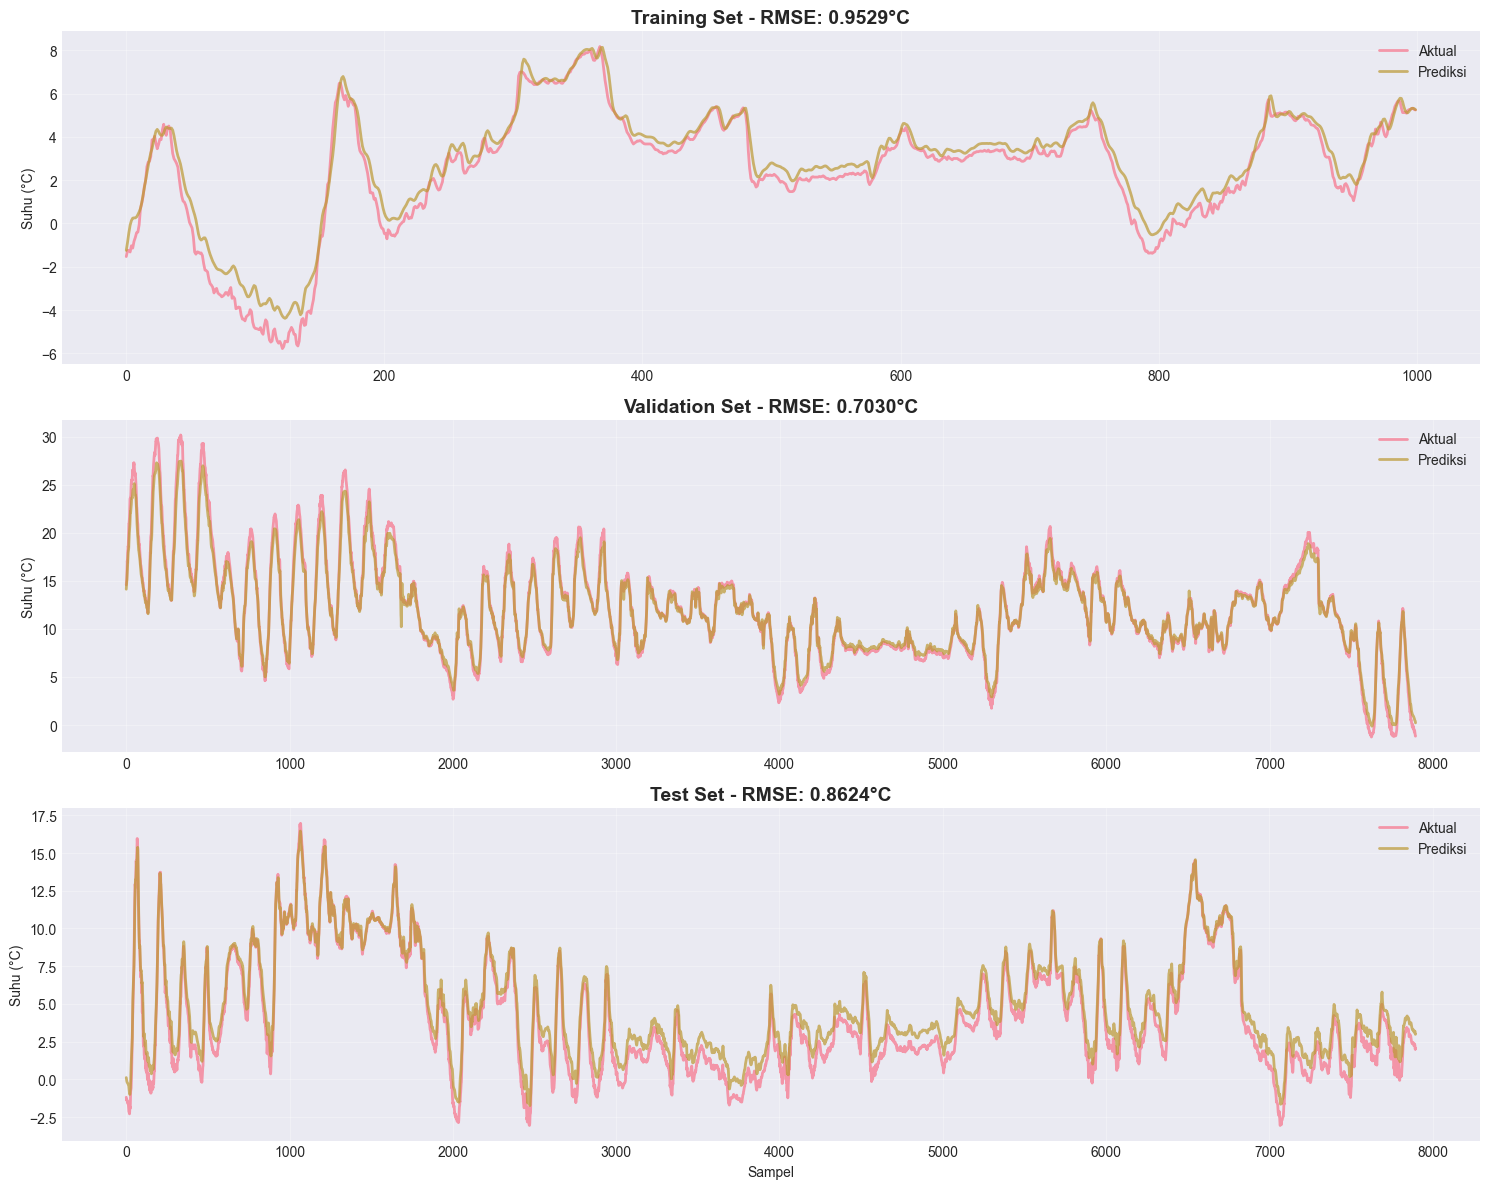

In [22]:
# Plot prediksi vs aktual untuk semua dataset
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Training
axes[0].plot(y_train_actual[:1000], label='Aktual', linewidth=2, alpha=0.7)
axes[0].plot(y_train_pred_actual[:1000], label='Prediksi', linewidth=2, alpha=0.7)
axes[0].set_title(f'Training Set - RMSE: {train_metrics[0]:.4f}°C', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Suhu (°C)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].plot(y_val_actual, label='Aktual', linewidth=2, alpha=0.7)
axes[1].plot(y_val_pred_actual, label='Prediksi', linewidth=2, alpha=0.7)
axes[1].set_title(f'Validation Set - RMSE: {val_metrics[0]:.4f}°C', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Suhu (°C)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Test
axes[2].plot(y_test_actual, label='Aktual', linewidth=2, alpha=0.7)
axes[2].plot(y_test_pred_actual, label='Prediksi', linewidth=2, alpha=0.7)
axes[2].set_title(f'Test Set - RMSE: {test_metrics[0]:.4f}°C', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Sampel')
axes[2].set_ylabel('Suhu (°C)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

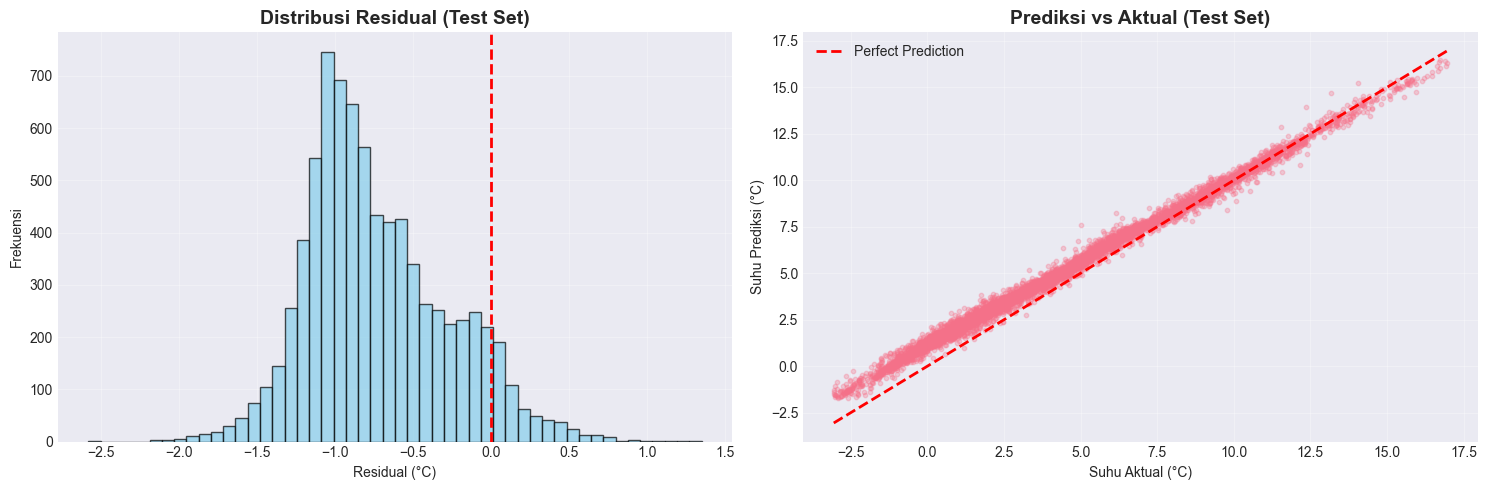

Mean Residual: -0.7324°C
Std Residual: 0.4554°C


In [23]:
# Residual Analysis
residuals_test = y_test_actual - y_test_pred_actual

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram residuals
axes[0].hist(residuals_test, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribusi Residual (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Residual (°C)')
axes[0].set_ylabel('Frekuensi')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

# Scatter plot: Predicted vs Actual
axes[1].scatter(y_test_actual, y_test_pred_actual, alpha=0.3, s=10)
axes[1].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Prediksi vs Aktual (Test Set)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Suhu Aktual (°C)')
axes[1].set_ylabel('Suhu Prediksi (°C)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean Residual: {residuals_test.mean():.4f}°C")
print(f"Std Residual: {residuals_test.std():.4f}°C")

## 13. Simpan Model & Scaler

In [24]:
# Simpan model final
model.save('models/lstm_temperature_model.h5')
print("✅ Model disimpan: models/lstm_temperature_model.h5")

# Simpan scaler
joblib.dump(scaler, 'models/scaler.save')
print("✅ Scaler disimpan: models/scaler.save")

# Simpan informasi model
model_info = {
    'timesteps': timesteps,
    'n_features': n_features,
    'fitur_model': fitur_model,
    'test_rmse': test_metrics[0],
    'test_mae': test_metrics[1],
    'test_r2': test_metrics[2]
}

import json
with open('models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
    
print("✅ Info model disimpan: models/model_info.json")

print("\n" + "="*60)
print("INFORMASI MODEL")
print("="*60)
for key, value in model_info.items():
    print(f"{key}: {value}")

✅ Model disimpan: models/lstm_temperature_model.h5
✅ Scaler disimpan: models/scaler.save
✅ Info model disimpan: models/model_info.json

INFORMASI MODEL
timesteps: 60
n_features: 8
fitur_model: ['suhu', 'kelembaban_relatif', 'tekanan_udara', 'kecepatan_angin', 'curah_hujan', 'radiasi_gelombang_pendek', 'bulan', 'hari_dalam_tahun']
test_rmse: 0.8624061237644545
test_mae: 0.7652028547301724
test_r2: 0.9488616985470468


## 14. Aplikasi Web Flask

Sekarang kita akan membuat aplikasi web Flask untuk menampilkan prediksi suhu.\n\n**Struktur folder yang diperlukan:**\n```\nproject/\n├── app.py\n├── templates/\n│   └── index.html\n├── static/\n│   └── plots/\n├── models/\n│   ├── lstm_temperature_model.h5\n│   ├── scaler.save\n│   └── model_info.json\n└── prediksi_cuaca_lstm.ipynb\n```

In [25]:
# Simpan dataframe untuk digunakan di Flask app
df_model.to_csv('data_for_app.csv')
print("✅ Data untuk aplikasi disimpan: data_for_app.csv")

✅ Data untuk aplikasi disimpan: data_for_app.csv


## 15. Kesimpulan

### Hasil yang Dicapai:
1. ✅ Dataset berhasil dimuat dan dibersihkan
2. ✅ EDA lengkap dengan visualisasi
3. ✅ Feature engineering (fitur waktu + rolling features)
4. ✅ Model LSTM berhasil dibangun dan dilatih
5. ✅ Evaluasi model dengan metrik RMSE, MAE, dan R²
6. ✅ Model dan scaler berhasil disimpan

### Metrik Performance (Test Set):
- **RMSE:** Lihat hasil evaluasi di atas
- **MAE:** Lihat hasil evaluasi di atas
- **R²:** Lihat hasil evaluasi di atas

### Langkah Selanjutnya:
1. Jalankan Flask application (`app.py`)
2. Deploy ke platform cloud (Render/Railway/Heroku)
3. Buat dokumentasi lengkap
4. Buat video presentasi

### Tips untuk Improvement:
- Coba hyperparameter tuning (units, layers, dropout)
- Eksperimen dengan timesteps yang berbeda (30, 60, 90)
- Tambahkan fitur exogenous lainnya
- Coba ensemble dengan model lain (GRU, Bidirectional LSTM)